In [5]:
!pip install yellowbrick

   ---------------------------------------- 282.6/282.6 kB 8.8 MB/s eta 0:00:00


In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import pandas as pd
pd.set_option('display.max_columns',None)
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn import preprocessing,cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_samples,silhouette_score,davies_bouldin_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import statsmodels as sm
from scipy import stats

from time import time

from imblearn.under_sampling import RandomUnderSampler

from warnings import simplefilter
simplefilter("ignore")

In [7]:
data = pd.read_csv(r'C:\Users\dell\Desktop\MyDocs\Docs\MK\travel.csv')

data.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83


In [8]:
data['srch_destination_type_id'].unique().shape

(8,)

In [9]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns.')

The data has 100000 rows and 25 columns.


In [10]:
print(f'Total number of missing values: {data.isnull().sum().sum()}')

Total number of missing values: 36329


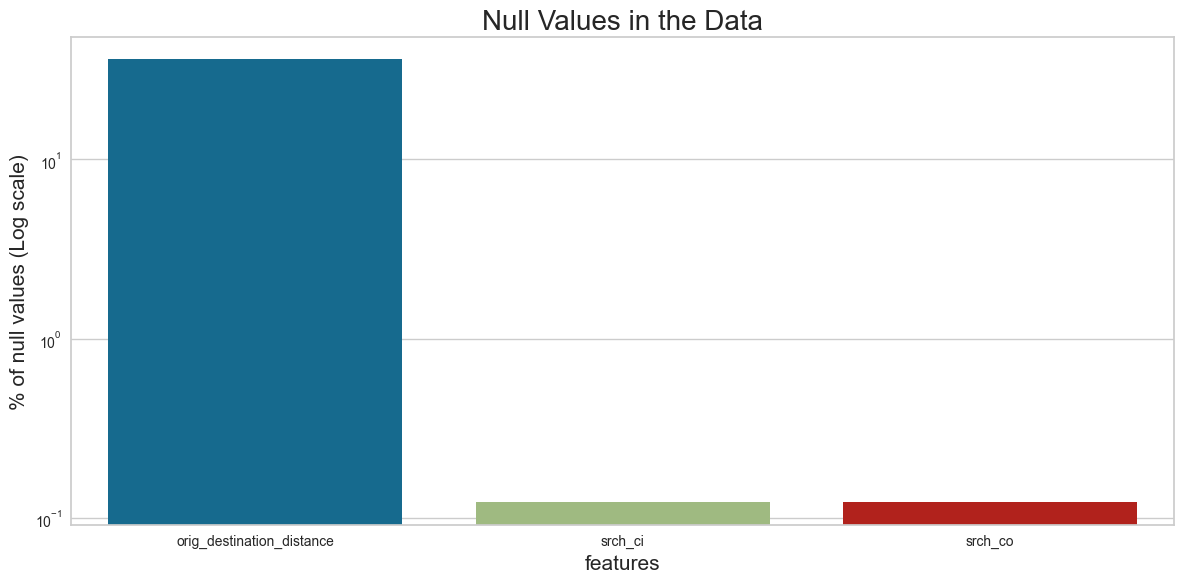

In [11]:
def plot_nulls(data,title,x_axis_label,y_axis_label):
    
    # number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    plt.figure(figsize=(12,6))
    sns.barplot(data_nulls.loc[data_nulls['count'] > 0],x="index",y="count")
    plt.yscale('log')
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=15)
    plt.ylabel(y_axis_label,fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
    
plot_nulls(data,"Null Values in the Data",'features','% of null values (Log scale)')  

In [12]:
print(f'There are {data.duplicated().sum()} duplicate rows in the dataset.')

There are 0 duplicate rows in the dataset.


In [13]:
print(f'Number of unique values in the dataset: \n\n {data.nunique()}')

Number of unique values in the dataset: 

 Unnamed: 0                   100000
date_time                     99886
site_name                        41
posa_continent                    5
user_location_country           201
user_location_region            779
user_location_city            10779
orig_destination_distance     62206
user_id                       88863
is_mobile                         2
is_package                        2
channel                          11
srch_ci                        1066
srch_co                        1068
srch_adults_cnt                  10
srch_children_cnt                10
srch_rm_cnt                       9
srch_destination_id            8827
srch_destination_type_id          8
is_booking                        2
cnt                              32
hotel_continent                   7
hotel_country                   178
hotel_market                   1843
hotel_cluster                   100
dtype: int64


In [14]:
data.shape

(100000, 25)

In [15]:
data.describe()

,Unnamed: 0,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,63915.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.882530e+07,9.838570,2.678150,85.995070,308.636990,27676.391240,1960.661721,6.054383e+05,0.133770,0.248140,5.858590,2.020710,0.336750,1.111750,14426.32738,2.577290,0.079930,1.487980,3.150920,81.093290,598.848330,49.860370
std,1.086183e+07,11.996426,0.749018,59.292002,208.706581,16768.647409,2228.153377,3.516154e+05,0.340407,0.431936,3.722823,0.909774,0.734449,0.451602,11036.98122,2.149263,0.271186,1.280262,1.620534,56.111519,510.959297,28.885423
min,1.012000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.005600,1.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9.448967e+06,2.000000,3.000000,66.000000,174.000000,12949.000000,312.792100,2.987962e+05,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,8267.00000,1.000000,0.000000,1.000000,2.000000,50.000000,158.000000,25.000000
50%,1.881212e+07,2.000000,3.000000,66.000000,314.000000,27655.000000,1131.835300,6.028825e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,9145.00000,1.000000,0.000000,1.000000,2.000000,50.000000,591.000000,49.000000
75%,2.825307e+07,15.000000,3.000000,70.000000,385.000000,42328.000000,2542.359350,9.157222e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,18784.00000,5.000000,0.000000,2.000000,4.000000,106.000000,701.000000,73.000000
max,3.767009e+07,53.000000,4.000000,239.000000,1025.000000,56507.000000,11965.376100,1.198783e+06,1.000000,1.000000,10.000000,9.000000,9.000000,8.000000,65035.00000,9.000000,1.000000,120.000000,6.000000,212.000000,2117.000000,99.000000


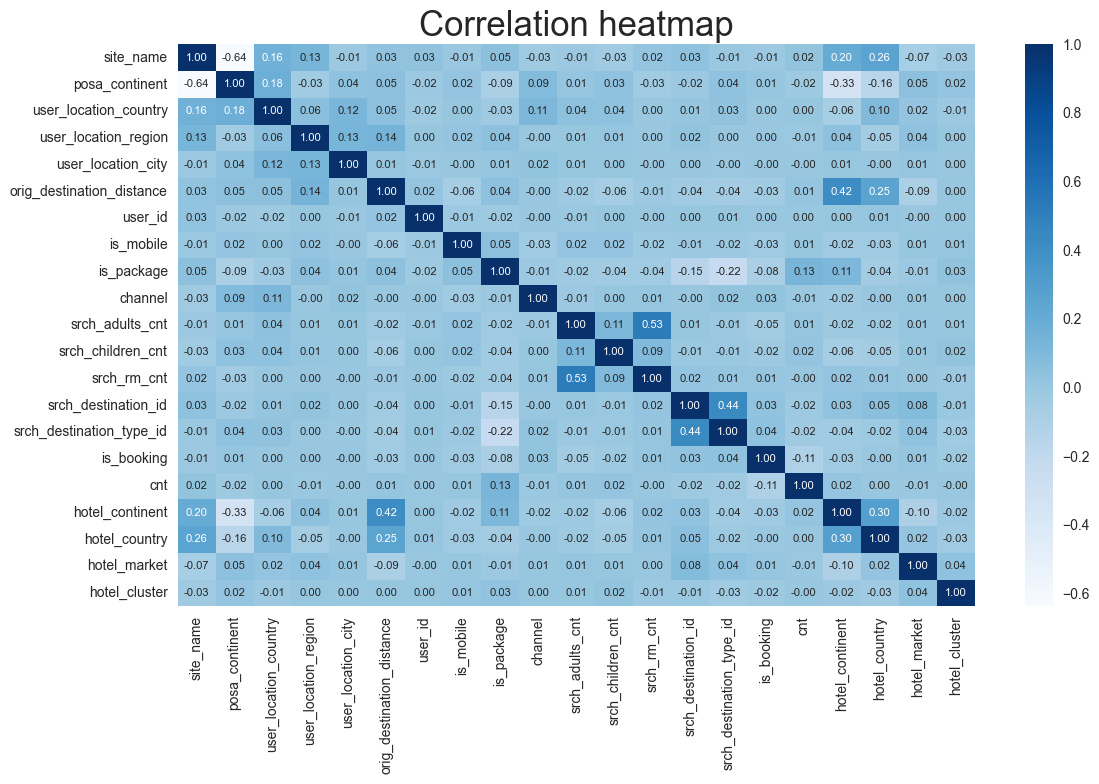

In [16]:
corr_travel = data.drop(['Unnamed: 0','date_time','srch_ci','srch_co'],axis=1)

# Create correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_travel.corr(method='pearson'),annot=True,fmt='.2f',annot_kws={"fontsize":8},cmap='Blues')
plt.title('Correlation heatmap',fontsize=25)

plt.tight_layout()
plt.show()

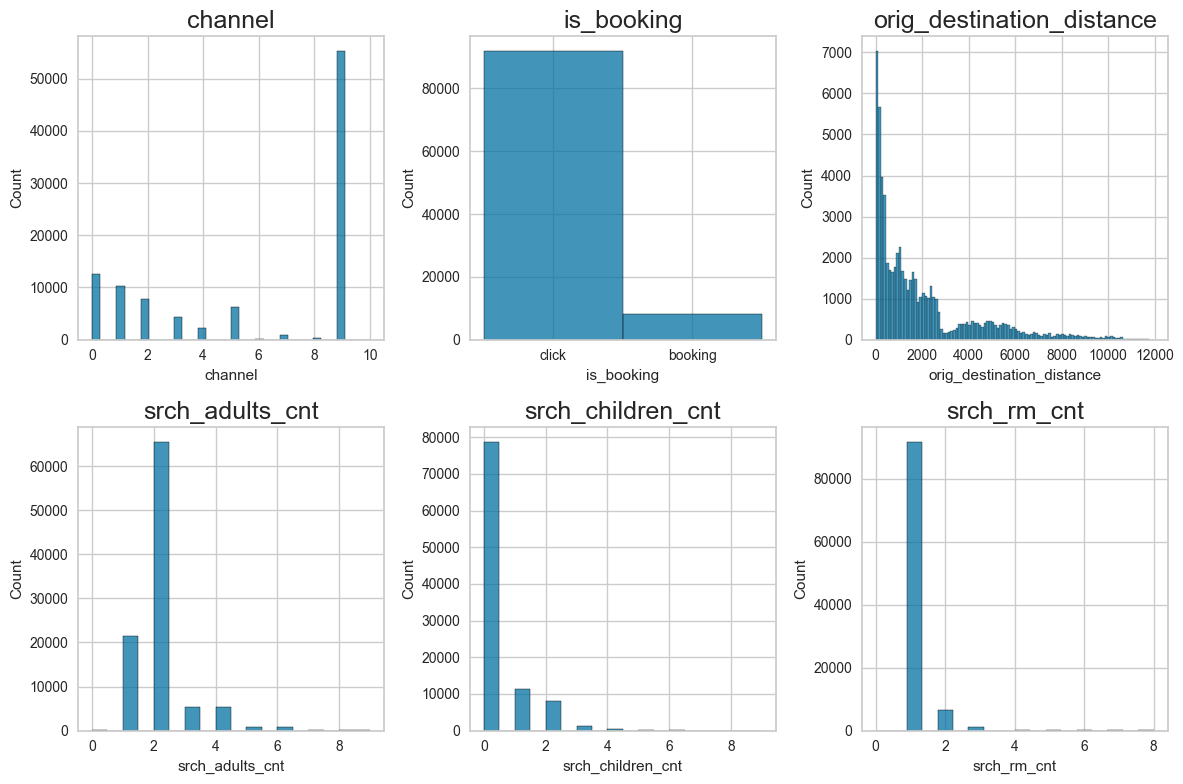

In [17]:
plotted_columns = data[['channel','is_booking','orig_destination_distance','srch_adults_cnt','srch_children_cnt','srch_rm_cnt']]
plotted_columns['is_booking'] = plotted_columns['is_booking'].map({1:'booking',0:'click'})

fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(12,8))    
axes = axes.flatten()         

for ax,col in zip(axes,plotted_columns.columns):
    sns.histplot(plotted_columns[col],ax=ax)
    ax.set_title(col,size=18)
    plt.tight_layout()  

In [18]:
data['is_booking'].value_counts() * 100 /data.shape[0]

0    92.007
1     7.993
Name: is_booking, dtype: float64

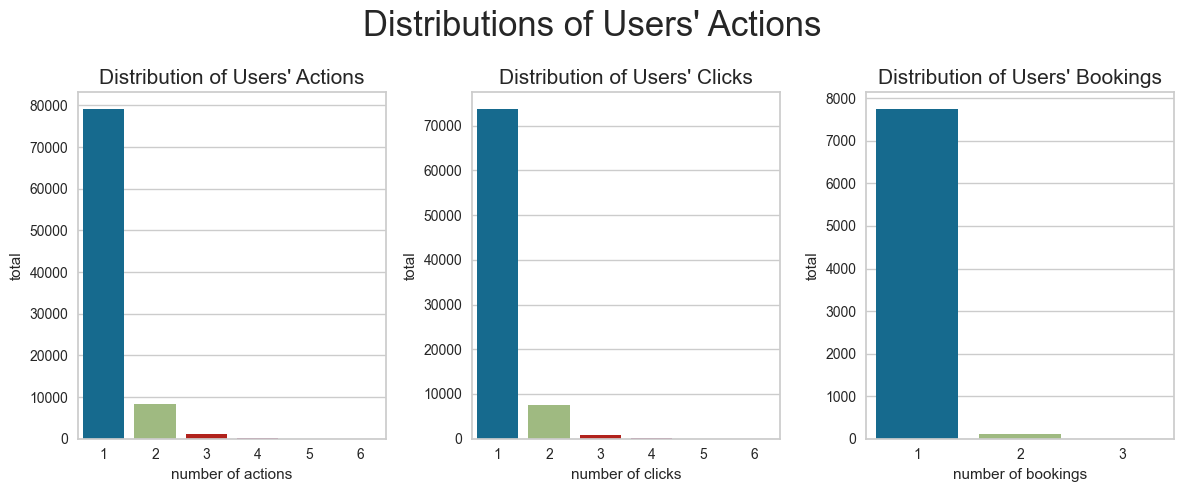

In [19]:
##########################
user_actions = data.groupby(['user_id'])['is_booking'].count().reset_index(name='action_count')

tot_user_actions = user_actions.groupby('action_count')['action_count'].count().reset_index(name='total')

user_clicks = data.loc[data.is_booking == 0].groupby(['user_id'])['is_booking'].count().reset_index(name='click_count')

tot_user_clicks = user_clicks.groupby('click_count')['click_count'].count().reset_index(name='total')

user_bookings = data.loc[data.is_booking == 1].groupby(['user_id'])['is_booking'].count().reset_index(name='booking_count')

tot_user_bookings = user_bookings.groupby('booking_count')['booking_count'].count().reset_index(name='total')
##########################

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

ax1 = sns.barplot(data=tot_user_actions,x='action_count',y='total',ax=ax1)
ax1.set_xlabel('number of actions')
ax1.set_title("Distribution of Users' Actions",size=15)

ax2 = sns.barplot(data=tot_user_clicks,x='click_count',y='total',ax=ax2)
ax2.set_xlabel('number of clicks')
ax2.set_title("Distribution of Users' Clicks",size=15)

ax3 = sns.barplot(data=tot_user_bookings,x='booking_count',y='total',ax=ax3)
ax3.set_xlabel('number of bookings')
ax3.set_title("Distribution of Users' Bookings",size=15)

plt.suptitle("Distributions of Users' Actions",size=25)

plt.tight_layout()

In [20]:
user_actions.loc[user_actions['action_count'] >2]

,user_id,action_count
115,1751,3
130,1923,4
167,2249,3
220,2916,3
223,2956,5
...,...,...
88680,1196697,3
88689,1196792,3
88691,1196809,3
88731,1197187,4


In [21]:
data.loc[data['user_id'] == 2956]

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
10590,11880843,2013-06-08 21:29:01,2,3,66,174,5938,3303.2730,2956,0,0,9,2013-06-28,2013-06-29,2,0,1,12257,6,1,1,4,51,1509,47
34654,11880802,2013-02-22 12:17:26,2,3,66,174,5938,258.9861,2956,0,0,9,2013-03-25,2013-03-26,2,0,1,8250,1,1,1,2,50,628,1
58503,11880825,2013-04-01 17:11:01,2,3,162,28,572,NaN,2956,0,0,1,2013-04-01,2013-04-04,2,0,1,33942,1,0,1,4,124,1938,81
79887,11880807,2013-03-12 16:40:28,2,3,66,174,5938,2266.4568,2956,0,0,3,2013-03-28,2013-03-29,2,0,1,8260,1,0,1,2,50,701,17
94389,11880901,2014-10-09 17:14:41,2,3,66,174,20390,124.5951,2956,0,0,1,2014-10-16,2014-10-18,1,0,1,245,3,1,1,2,50,365,50


In [22]:
data = data.merge(user_actions,on='user_id',how='left')
data = data.merge(user_clicks,on='user_id',how='left')
data = data.merge(user_bookings,on='user_id',how='left')

In [23]:
data['click_count'].isnull().sum(), data['booking_count'].isnull().sum()

(6680, 90484)

In [24]:
data['click_count']   = data['click_count'].fillna(0)
data['booking_count'] = data['booking_count'].fillna(0)

data['click_count'].isnull().sum(), data['booking_count'].isnull().sum()

(0, 0)

In [25]:
data.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,action_count,click_count,booking_count
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2,2.0,0.0
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1,1.0,0.0
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1,1.0,0.0
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,1.0,1.0
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83,1,1.0,0.0


In [26]:
data[data['user_id'] == 106611]

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,action_count,click_count,booking_count
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,1.0,1.0
76497,4691128,2014-07-22 12:22:25,11,3,205,411,54864,209.6633,106611,0,0,0,2014-07-29,2014-08-01,1,0,1,9819,3,0,2,2,198,1234,90,2,1.0,1.0


In [27]:
data_count0 = data.loc[((data.srch_adults_cnt) + (data.srch_children_cnt)) == 0]

data_count0

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,action_count,click_count,booking_count
115,11473397,2014-10-07 14:43:37,2,3,66,293,52284,NaN,909952,0,1,9,2015-01-10,2015-01-15,0,0,1,8250,1,0,1,2,50,628,1,1,1.0,0.0
496,24467491,2013-06-15 19:12:59,29,1,52,40,29080,NaN,150434,0,1,9,2013-09-16,2013-09-20,0,0,2,25408,6,0,2,6,15,1534,46,1,1.0,0.0
1261,9475782,2014-10-26 10:20:35,2,3,66,220,22648,5148.4830,588617,1,1,2,2015-08-24,2015-09-03,0,0,1,8746,1,0,1,6,105,29,78,1,1.0,0.0
1428,17753458,2014-11-16 10:21:59,2,3,66,174,53801,1638.7472,207522,1,1,0,2015-04-18,2015-04-25,0,0,1,8810,1,0,1,4,8,1532,52,1,1.0,0.0
1539,8869536,2014-12-28 19:16:12,2,3,66,363,31138,1526.8518,938404,0,1,0,NaN,NaN,0,0,1,8277,1,0,1,2,50,412,9,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95299,35675080,2014-03-15 16:49:48,23,1,1,318,2096,1088.1394,1020200,0,1,0,2014-05-24,2014-05-31,0,0,1,22889,1,0,4,6,208,1798,67,1,1.0,0.0
95832,28204609,2014-03-07 11:34:55,2,3,66,324,44585,1356.9140,776221,0,1,1,2014-05-28,2014-06-02,0,0,1,1152,1,0,2,4,47,1502,42,1,1.0,0.0
96165,22532793,2014-08-10 15:09:28,2,3,66,442,28620,767.7554,67291,0,1,5,2014-10-02,2014-10-04,0,0,1,8236,1,0,1,2,50,656,59,2,2.0,0.0
97822,24919526,2014-05-10 00:55:09,2,3,66,153,20706,258.1804,577044,0,1,1,2014-05-11,2014-05-14,0,0,1,8250,1,0,2,2,50,628,47,1,1.0,0.0


In [28]:
data_children_alone = data.loc[data.srch_adults_cnt == 0]

data_children_alone

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,action_count,click_count,booking_count
115,11473397,2014-10-07 14:43:37,2,3,66,293,52284,NaN,909952,0,1,9,2015-01-10,2015-01-15,0,0,1,8250,1,0,1,2,50,628,1,1,1.0,0.0
496,24467491,2013-06-15 19:12:59,29,1,52,40,29080,NaN,150434,0,1,9,2013-09-16,2013-09-20,0,0,2,25408,6,0,2,6,15,1534,46,1,1.0,0.0
545,20749225,2014-09-25 09:14:45,2,3,63,451,14872,NaN,14297,0,1,1,2014-10-21,2014-10-24,0,2,1,8253,1,0,2,6,70,19,69,1,1.0,0.0
1261,9475782,2014-10-26 10:20:35,2,3,66,220,22648,5148.4830,588617,1,1,2,2015-08-24,2015-09-03,0,0,1,8746,1,0,1,6,105,29,78,1,1.0,0.0
1428,17753458,2014-11-16 10:21:59,2,3,66,174,53801,1638.7472,207522,1,1,0,2015-04-18,2015-04-25,0,0,1,8810,1,0,1,4,8,1532,52,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95832,28204609,2014-03-07 11:34:55,2,3,66,324,44585,1356.9140,776221,0,1,1,2014-05-28,2014-06-02,0,0,1,1152,1,0,2,4,47,1502,42,1,1.0,0.0
96165,22532793,2014-08-10 15:09:28,2,3,66,442,28620,767.7554,67291,0,1,5,2014-10-02,2014-10-04,0,0,1,8236,1,0,1,2,50,656,59,2,2.0,0.0
97822,24919526,2014-05-10 00:55:09,2,3,66,153,20706,258.1804,577044,0,1,1,2014-05-11,2014-05-14,0,0,1,8250,1,0,2,2,50,628,47,1,1.0,0.0
97998,14688274,2014-03-06 20:50:46,2,3,66,256,54612,2319.1694,576373,1,1,9,2014-11-28,2014-12-12,0,0,1,5405,6,0,1,4,8,126,73,1,1.0,0.0


In [29]:
rows_to_drop = pd.concat([data_count0,data_children_alone]).drop_duplicates()

print(f'Number of rows to drop: {len(rows_to_drop)}') 
print(f'Expected length of the dataframe after dropping these rows: {len(data) - len(rows_to_drop)}')

Number of rows to drop: 181
Expected length of the dataframe after dropping these rows: 99819


In [30]:
data.drop(rows_to_drop.index,inplace=True)

len(data)

99819

In [31]:
# Changing the column type to datetime type using pandas
data['srch_co']   = pd.to_datetime(data['srch_co'])
data['srch_ci']   = pd.to_datetime(data['srch_ci'])
data['date_time'] = pd.to_datetime(data['date_time'])

# Change the timestamp of 'date_time' (the hour is removed)
data['date'] = pd.to_datetime(data['date_time'].apply(lambda x: x.date()))

data.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,action_count,click_count,booking_count,date
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2,2.0,0.0,2014-11-03
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1,1.0,0.0,2013-03-13
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1,1.0,0.0,2014-10-13
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,1.0,1.0,2013-11-05
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83,1,1.0,0.0,2014-06-10


In [32]:
# Remove the rows where the check-in does not occur before than the check-out
data = data.loc[data.srch_ci < data.srch_co]

len(data)

99316

In [33]:
# Remove rows where the check-in does not occur before than the booking
data = data.loc[data.date < data.srch_ci]

len(data)

96355

In [34]:
# Define 'travel_duration'
data['travel_duration'] = (data.srch_co - data.srch_ci).dt.days

In [35]:
data['days_in_advance'] = (data.srch_ci - data.date).dt.days

In [36]:
data.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,action_count,click_count,booking_count,date,travel_duration,days_in_advance
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2,2.0,0.0,2014-11-03,4,42
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1,1.0,0.0,2014-10-13,7,172
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,1.0,1.0,2013-11-05,1,2
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83,1,1.0,0.0,2014-06-10,5,54
6,24023139,2014-01-28 13:16:36,2,3,66,337,54287,329.1833,908558,0,0,2,2014-02-27,2014-03-01,2,0,1,8287,1,1,1,2,198,400,6,1,0.0,1.0,2014-01-28,2,30


In [37]:
booking_channels = data.groupby('channel')['is_booking'].mean().reset_index(name='avg_booking')

interaction_count = data.groupby('channel')['is_booking'].count().reset_index(name='interaction_count')

booking_count = data.loc[data.is_booking == 1].groupby('channel')['is_booking'].count().reset_index(name='booking_count')

booking_channels = booking_channels.merge(booking_count,on='channel')
booking_channels = booking_channels.merge(interaction_count,on='channel').sort_values('interaction_count',ascending=False)

booking_channels

,channel,avg_booking,booking_count,interaction_count
9,9,0.081580,4334,53126
0,0,0.068320,821,12017
1,1,0.066862,663,9916
2,2,0.059858,456,7618
5,5,0.093293,562,6024
3,3,0.060423,260,4303
4,4,0.116737,249,2133
7,7,0.044643,35,784
8,8,0.050000,13,260
6,6,0.069182,11,159


In [38]:
def stats_comparison():

    cat = booking_channels[['channel','avg_booking','booking_count']]
    
    overall_average = data['is_booking'].mean()
    overall_bookings = booking_channels['booking_count'].sum()

    # Sum of the other types of bookings
    cat['rest_bookings'] = overall_bookings - cat['booking_count']
    # Average of the other bookings.
    cat['rest_average'] = (overall_bookings*overall_average - cat['booking_count']*cat['avg_booking'])/cat['rest_bookings']

    # A z-score is the number of standard deviations from the mean a data point is.
    # We get the z-scores for channel average compared to the average of the others (excluding the channel we are analyzing)
    cat['z_score'] = (cat['avg_booking']-cat['rest_average'])/np.sqrt(overall_average*(1-overall_average)*(1/cat['booking_count']+1/cat['rest_bookings']))
    cat['prob'] = np.around(stats.norm.cdf(cat.z_score),decimals=10)
    cat['significant'] = [(lambda x: 1 if x > 0.9 else -1 if x < 0.1 else 0)(i) for i in cat['prob']]
    
    return cat


stats = stats_comparison()
stats

,channel,avg_booking,booking_count,rest_bookings,rest_average,z_score,prob,significant
9,9,0.081580,4334,3073,0.070233,1.806235,0.964559,1
0,0,0.068320,821,6586,0.077938,-0.975528,0.164649,0
1,1,0.066862,663,6744,0.077856,-1.014036,0.155283,0
2,2,0.059858,456,6951,0.077988,-1.407878,0.079584,-1
5,5,0.093293,562,6845,0.075524,1.520200,0.935770,1
3,3,0.060423,260,7147,0.077470,-1.013610,0.155384,0
4,4,0.116737,249,7158,0.075485,2.402159,0.991851,1
7,7,0.044643,35,7372,0.077025,-0.717457,0.236546,0
8,8,0.050000,13,7394,0.076919,-0.364031,0.357918,0
6,6,0.069182,11,7396,0.076883,-0.095809,0.461836,0


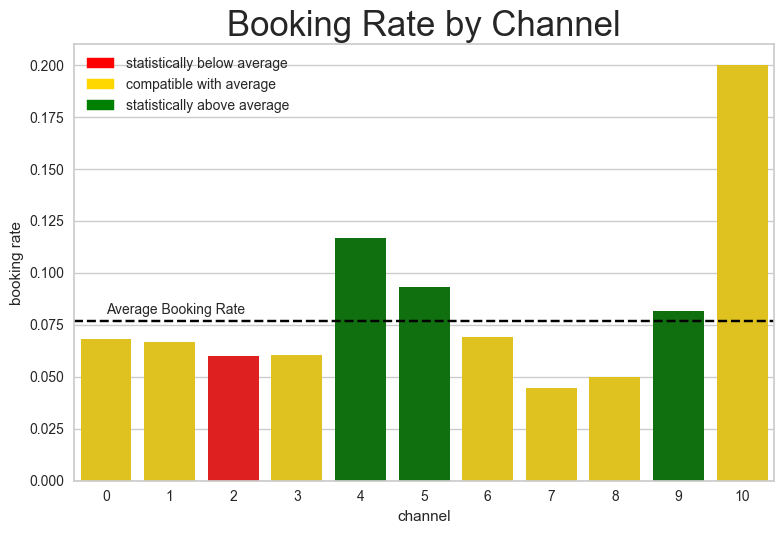

In [39]:
ax = sns.barplot(data=stats,x='channel',y='avg_booking',palette=['gold','gold','red','gold','green','green','gold','gold','gold','green','gold'])

ax.axhline(y=data['is_booking'].mean(),color='black',linestyle='--')
ax.text(0,0.08,'Average Booking Rate',fontsize=10)
ax.set_ylabel('booking rate')

red_patch    = mpatches.Patch(color='red',label='statistically below average')
yellow_patch = mpatches.Patch(color='gold',label='compatible with average')
green_patch  = mpatches.Patch(color='green',label='statistically above average')
plt.legend(handles=[red_patch,yellow_patch,green_patch])

ax.set_title('Booking Rate by Channel',size=25)

plt.tight_layout()

In [40]:
data.columns

Index(['Unnamed: 0', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'action_count', 'click_count', 'booking_count', 'date',
       'travel_duration', 'days_in_advance'],
      dtype='object')

In [41]:
X = data.drop(columns=['is_booking']).select_dtypes(include=[np.number])  # Replace 'booked' with actual target variable
y = data['is_booking']

In [42]:
X = X.fillna(X.median())

In [43]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [46]:
y_scores = model.predict_proba(X_test)[:, 1]

In [47]:
y_scores[:5]

array([2.49413259e-05, 1.43324727e-03, 2.71669774e-04, 1.11035732e-03,
       7.87618375e-04])

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [49]:
pr_df = pd.DataFrame()
pr_df['precision'] = precision
pr_df['recall'] = recall

In [50]:
len(thresholds)

11540

In [51]:
pr_df.head()

,precision,recall
0,0.128596,1.000000
1,0.128521,0.999326
2,0.128532,0.999326
3,0.128543,0.999326
4,0.128554,0.999326


In [52]:
pr_auc = auc(recall, precision)

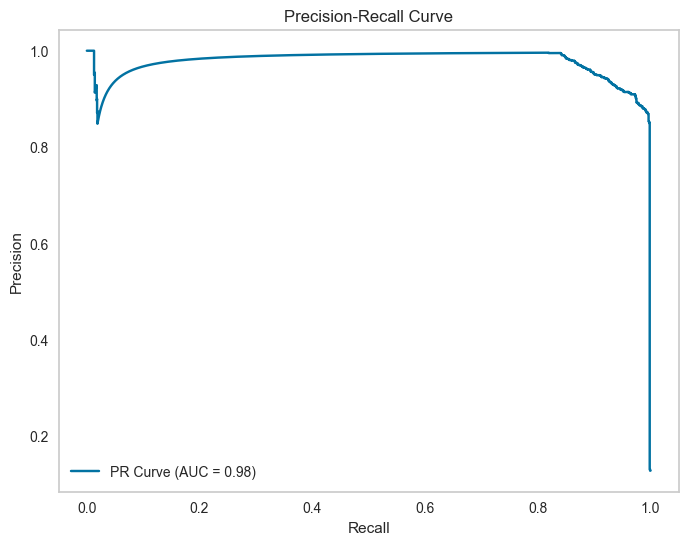

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

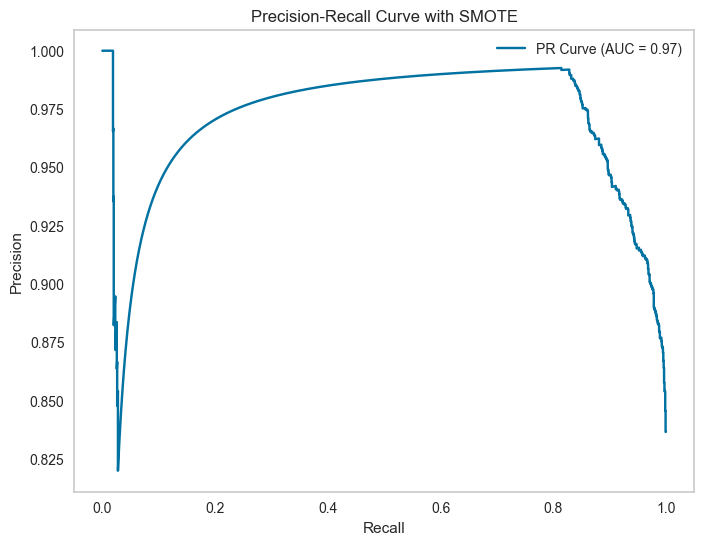

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Logistic Regression model
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Get predictions
y_scores = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate AUC of PR Curve
pr_auc = auc(recall, precision)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with SMOTE')
plt.legend()
plt.grid()
plt.show()

In [55]:
# Our selected features
features = ['travel_duration',
            'days_in_advance',
            'orig_destination_distance',
            'srch_adults_cnt',
            'srch_children_cnt',
            'srch_rm_cnt']

city_data = data.dropna(axis=0)[features + ['user_location_city']]

city_groups = city_data.groupby('user_location_city').mean().reset_index().dropna(axis=0)

city_groups.head()

,user_location_city,travel_duration,days_in_advance,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
0,0,2.0000,78.50,2315.83625,1.7500,0.00,1.0
1,3,4.5625,92.25,3550.01750,1.9375,0.50,1.0
2,7,14.0000,58.00,5994.86400,2.0000,0.00,1.0
3,14,7.0000,35.75,5342.81910,2.0000,0.75,1.0
4,21,5.0000,31.50,2165.76890,1.5000,1.00,1.0


In [56]:
len(city_groups), len(data)

(4478, 96355)

In [57]:
city_groups_scl = city_groups.copy()

### Scaling ###
scaler = MinMaxScaler() 

# Apply Min-Max Scaling
city_groups_scl[features] = scaler.fit_transform(city_groups_scl[features])

city_groups_scl.head()

,user_location_city,travel_duration,days_in_advance,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
0,0,0.025641,0.212329,0.202614,0.093750,0.00000,0.0
1,3,0.091346,0.250000,0.310612,0.117188,0.06250,0.0
2,7,0.333333,0.156164,0.524551,0.125000,0.00000,0.0
3,14,0.153846,0.095205,0.467493,0.125000,0.09375,0.0
4,21,0.102564,0.083562,0.189482,0.062500,0.12500,0.0


In [58]:
inertia = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=42)
    # k-means++ is an algorithm for choosing the initial values (or "seeds") for the k-means clustering algorithm.
    kmeans.fit(city_groups_scl[features])
    inertia.append(kmeans.inertia_)

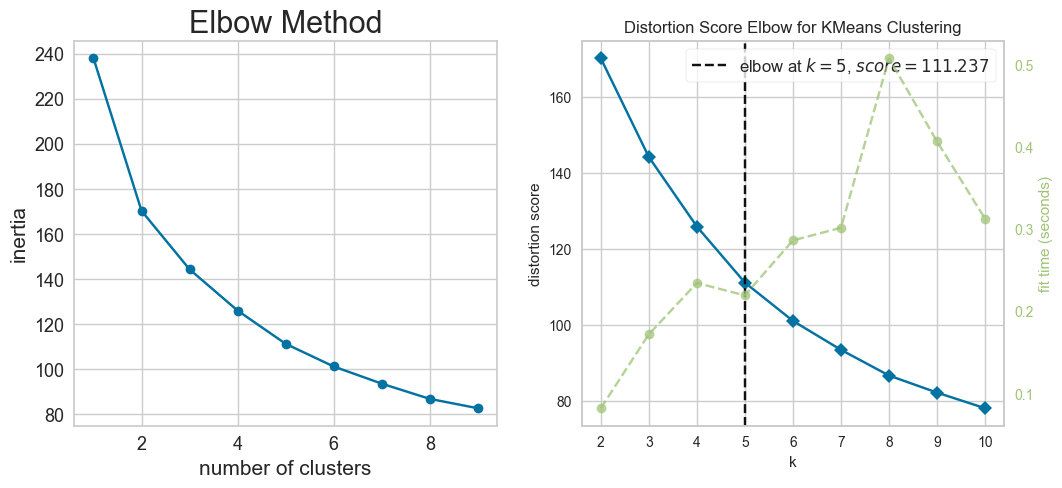

<Figure size 800x550 with 0 Axes>

In [59]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# First Plot
ax1.plot(range(1,10),inertia,marker='o',linestyle='-')
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax1.set_xlabel("number of clusters",fontsize=15)
ax1.set_ylabel('inertia',fontsize=15)
ax1.set_title("Elbow Method",fontsize=22)

# Second Plot
Elbow_M = KElbowVisualizer(KMeans(),k=10)
Elbow_M.fit(city_groups_scl[features])
ax2 = Elbow_M.show()

plt.tight_layout() 

In [60]:
silhouette_scores = []

range_clusters = range(2,11)

for i in range_clusters:
    kmeans = KMeans(n_clusters=i,random_state=0)
    labels = kmeans.fit_predict(city_groups_scl[features]) 
    score = silhouette_score(city_groups_scl[features],labels)
    silhouette_scores.append(score)

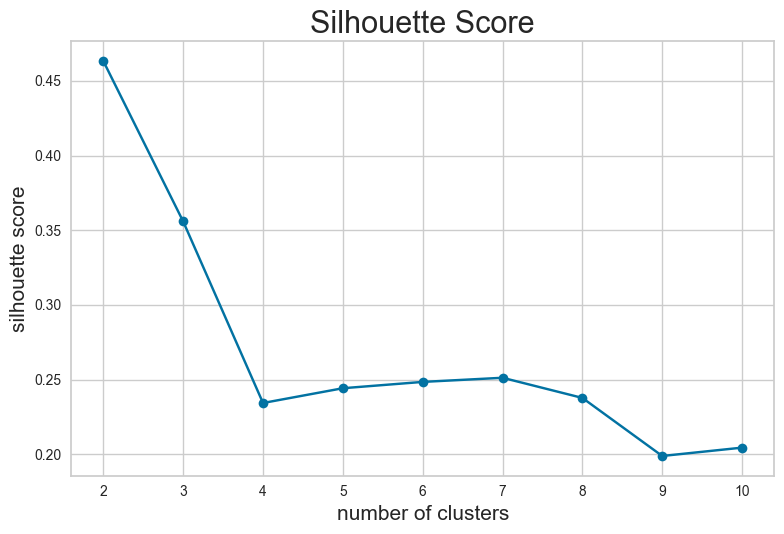

In [61]:
plt.plot(range_clusters,silhouette_scores,marker='o')
plt.xlabel("number of clusters",fontsize=15)
plt.ylabel('silhouette score',fontsize=15)
plt.title("Silhouette Score",fontsize=22)

plt.tight_layout()
plt.show()

In [62]:
# Initiating KMeans. n_clusters = 3
km = cluster.KMeans(n_clusters=3,max_iter=100,random_state=None)

# Fit model and predict clusters
yhat = km.fit_predict(city_groups_scl[features])
city_groups_scl["clusters_2D"] = yhat

# Adding the Clusters feature to the dataframe before scaling
city_groups["clusters_2D"] = yhat

city_groups_scl.head()

,user_location_city,travel_duration,days_in_advance,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,clusters_2D
0,0,0.025641,0.212329,0.202614,0.093750,0.00000,0.0,0
1,3,0.091346,0.250000,0.310612,0.117188,0.06250,0.0,1
2,7,0.333333,0.156164,0.524551,0.125000,0.00000,0.0,1
3,14,0.153846,0.095205,0.467493,0.125000,0.09375,0.0,1
4,21,0.102564,0.083562,0.189482,0.062500,0.12500,0.0,0


In [63]:
# Initiating PCA to reduce dimentions to 2
pca = PCA(n_components=2)

pca.fit(city_groups_scl[features]) 
city_groups_2D = pd.DataFrame(pca.transform(city_groups_scl[features]),columns=(["col1","col2"]))
city_groups_2D["clusters_2D"] = yhat
city_groups_2D.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,4478.0,-4.462710e-18,0.159786,-0.229839,-0.103307,-0.024091,0.056770,1.072509
col2,4478.0,-2.975140e-18,0.106840,-0.505588,-0.047630,-0.008233,0.042246,0.628575
clusters_2D,4478.0,3.838767e-01,0.713493,0.000000,0.000000,0.000000,0.000000,2.000000


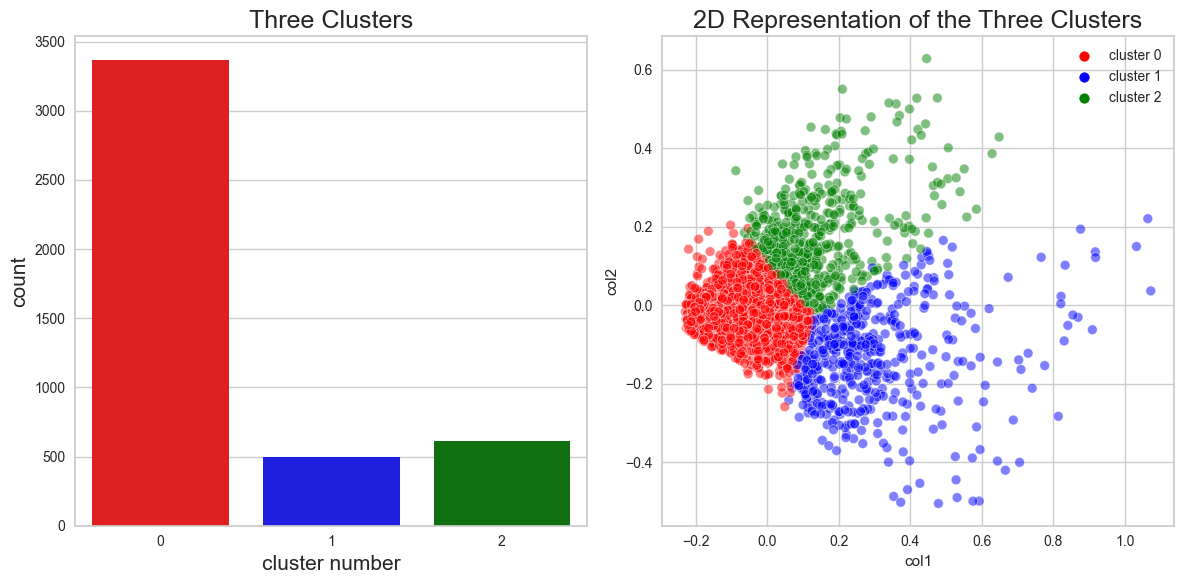

In [64]:
cluster_count = city_groups_2D.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count',ascending=False)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

# First Plot
ax1 = sns.barplot(x='clusters_2D',y='count',data=cluster_count,ax=ax1,palette=['red','blue','green'])
ax1.set_xlabel("cluster number",fontsize=15)
ax1.set_ylabel('count',fontsize=15)
ax1.set_title("Three Clusters",fontsize=18)

ax2 = sns.scatterplot(x="col1",y="col2",data=city_groups_2D,hue="clusters_2D",ax=ax2,palette=['red','blue','green'],alpha=0.5)
ax2.set_title("2D Representation of the Three Clusters",fontsize=18)
legend_handles,_ = ax2.get_legend_handles_labels()
ax2.legend(legend_handles,['cluster 0','cluster 1','cluster 2'])

plt.tight_layout()

In [65]:
# Initiating PCA to reduce dimentions to 3
pca = PCA(n_components=3)

pca.fit(city_groups_scl[features]) 
city_groups_3D = pd.DataFrame(pca.transform(city_groups_scl[features]),columns=(["col1","col2","col3"]))
city_groups_3D["clusters_3D"] = yhat
city_groups_3D.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,4478.0,-4.760224e-18,0.159786,-0.229839,-0.103307,-0.024091,0.056770,1.072509
col2,4478.0,-7.685778e-19,0.106840,-0.505588,-0.047630,-0.008233,0.042246,0.628575
col3,4478.0,1.487570e-18,0.085835,-0.239347,-0.036758,-0.011903,0.015783,0.986675
clusters_3D,4478.0,3.838767e-01,0.713493,0.000000,0.000000,0.000000,0.000000,2.000000


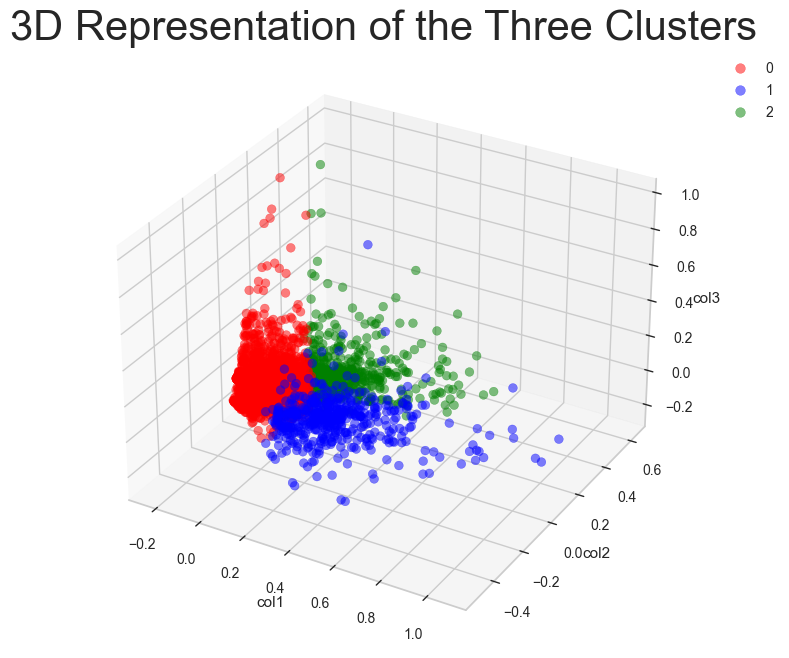

In [66]:
x = city_groups_3D['col1']
y = city_groups_3D['col2']
z = city_groups_3D['col3']
c = city_groups_3D["clusters_3D"]

# Axes instance
fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.set_title('3D Representation of the Three Clusters',size=30)

# Get colormap from seaborn
cmap = ListedColormap(sns.color_palette(palette=['red','blue','green']))

# Plot
sc = ax.scatter(x,y,z,s=40,c=c,marker='o',cmap=cmap,alpha=0.5)
ax.set_xlabel('col1')
ax.set_ylabel('col2')
ax.set_zlabel('col3')

# Legend
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1.05,1),loc=2)

plt.tight_layout()

In [67]:
city_groups_scl2 = city_groups_scl.copy()
city_groups2 = city_groups.copy()

# Initiating KMeans. n_clusters = 5
km = cluster.KMeans(n_clusters=5,max_iter=100,random_state=None)

# Fit model and predict clusters
yhat2 = km.fit_predict(city_groups_scl2[features])
city_groups_scl2["clusters_2D"] = yhat2

# Adding the Clusters feature to the dataframe before scaling
city_groups2["clusters_2D"] = yhat2

city_groups_scl2.head()

,user_location_city,travel_duration,days_in_advance,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,clusters_2D
0,0,0.025641,0.212329,0.202614,0.093750,0.00000,0.0,2
1,3,0.091346,0.250000,0.310612,0.117188,0.06250,0.0,2
2,7,0.333333,0.156164,0.524551,0.125000,0.00000,0.0,4
3,14,0.153846,0.095205,0.467493,0.125000,0.09375,0.0,4
4,21,0.102564,0.083562,0.189482,0.062500,0.12500,0.0,2


In [68]:
# Initiating PCA to reduce dimentions to 2
pca = PCA(n_components=2)

pca.fit(city_groups_scl2[features]) 
city_groups_2D2 = pd.DataFrame(pca.transform(city_groups_scl2[features]),columns=(["col1","col2"]))
city_groups_2D2["clusters_2D"] = yhat2
city_groups_2D2.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,4478.0,-5.454423e-18,0.159786,-0.229839,-0.103307,-0.024091,0.056770,1.072509
col2,4478.0,-8.677491e-19,0.106840,-0.505588,-0.047630,-0.008233,0.042246,0.628575
clusters_2D,4478.0,1.851050e+00,0.954826,0.000000,1.000000,2.000000,2.000000,4.000000


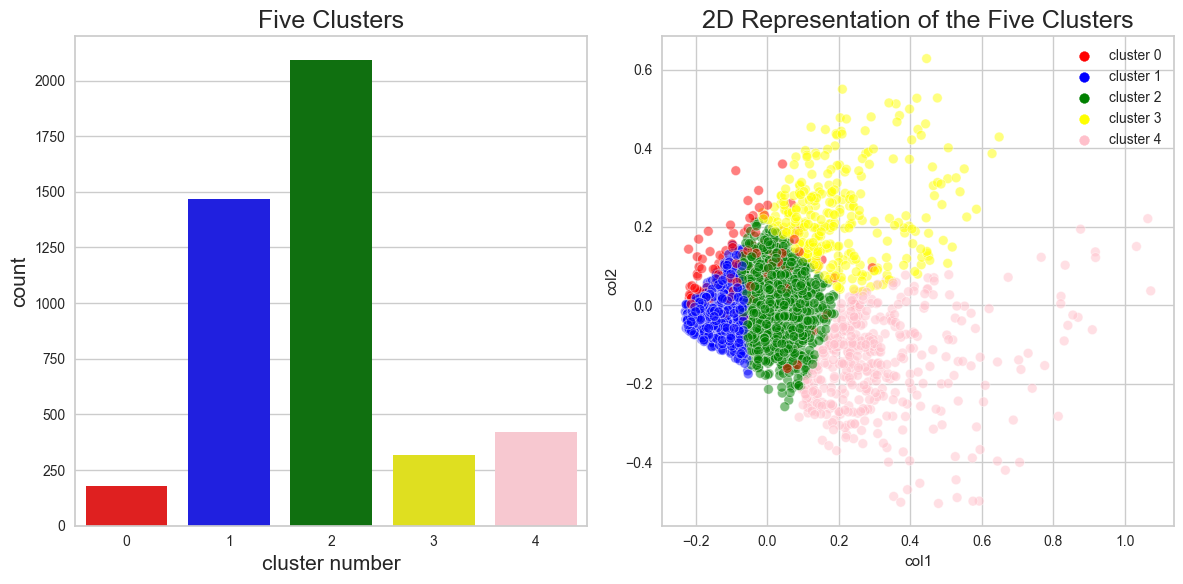

In [69]:
cluster_count2 = city_groups_2D2.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count',ascending=False)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

# First Plot
ax1 = sns.barplot(x='clusters_2D',y='count',data=cluster_count2,ax=ax1,palette=['red','blue','green','yellow','pink'])
ax1.set_xlabel("cluster number",fontsize=15)
ax1.set_ylabel('count',fontsize=15)
ax1.set_title("Five Clusters",fontsize=18)

ax2 = sns.scatterplot(x="col1",y="col2",data=city_groups_2D2,hue="clusters_2D",ax=ax2,palette=['red','blue','green','yellow','pink'],alpha=0.5)
ax2.set_title("2D Representation of the Five Clusters",fontsize=18)
legend_handles,_ = ax2.get_legend_handles_labels()
ax2.legend(legend_handles,['cluster 0','cluster 1','cluster 2','cluster 3','cluster 4'])

plt.tight_layout()

In [70]:
final_res = city_groups.groupby('clusters_2D')[['travel_duration','days_in_advance','orig_destination_distance','srch_adults_cnt','srch_children_cnt','srch_rm_cnt']].mean().reset_index()

final_res

,clusters_2D,travel_duration,days_in_advance,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
0,0,3.089123,40.668733,1311.397851,2.056777,0.376806,1.109310
1,1,4.461514,84.919586,5429.091296,2.035536,0.295943,1.095794
2,2,4.455456,132.573326,1800.702202,2.257811,0.393296,1.198617


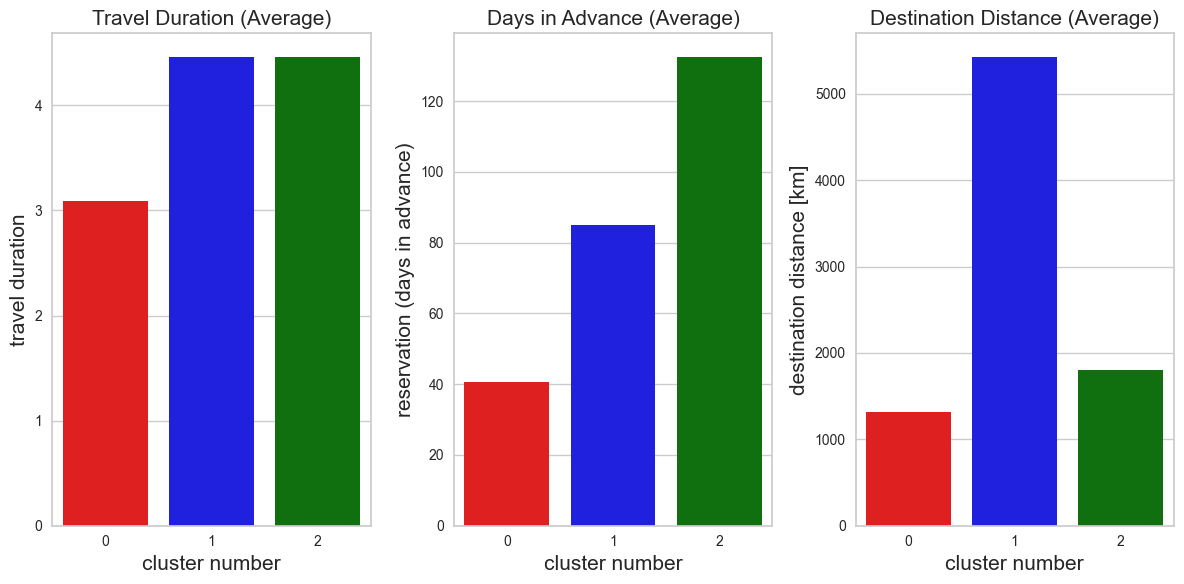

In [71]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

# First Plot
ax1 = sns.barplot(x='clusters_2D',y='travel_duration',data=final_res,ax=ax1,palette=['red','blue','green'])
ax1.set_xlabel("cluster number",fontsize=15)
ax1.set_ylabel('travel duration',fontsize=15)
ax1.set_title("Travel Duration (Average)",fontsize=15)

ax2 = sns.barplot(x='clusters_2D',y='days_in_advance',data=final_res,ax=ax2,palette=['red','blue','green'])
ax2.set_xlabel("cluster number",fontsize=15)
ax2.set_ylabel('reservation (days in advance)',fontsize=15)
ax2.set_title("Days in Advance (Average)",fontsize=15)

ax3 = sns.barplot(x='clusters_2D',y='orig_destination_distance',data=final_res,ax=ax3,palette=['red','blue','green'])
ax3.set_xlabel("cluster number",fontsize=15)
ax3.set_ylabel('destination distance [km]',fontsize=15)
ax3.set_title("Destination Distance (Average)",fontsize=15)

plt.tight_layout()